In [6]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad
from tqdm import tqdm

# ============================================
# Load Data
# ============================================

df = pd.read_csv('deaths.csv')  # shape: (weeks, states)
state_names = list(df.columns)
data = df.values.astype(np.float32)
data_max = np.max(data)
data_norm = data / data_max

deaths_tensor = torch.tensor(data_norm, dtype=torch.float32)  # (weeks, states)
num_weeks, num_states = deaths_tensor.shape

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ============================================
# SEIRM Model Dynamics
# ============================================

def seirm_derivatives(s, omega):
    S, E, I, R, M = s
    beta, alpha, gamma, mu = omega
    N = S + E + I + R
    dSdt = -beta * S * I / N
    dEdt = beta * S * I / N - alpha * E
    dIdt = alpha * E - gamma * I - mu * I
    dRdt = gamma * I
    dMdt = mu * I
    return torch.stack([dSdt, dEdt, dIdt, dRdt, dMdt], dim=0)

# ============================================
# PINN: Shared Time Module
# ============================================

class SharedTimeModule(nn.Module):
    def __init__(self, num_states, embedding_dim=8):
        super().__init__()
        self.state_embedding = nn.Embedding(num_states, embedding_dim)
        self.net = nn.Sequential(
            nn.Linear(1 + embedding_dim, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 5)
        )
        self.omega = nn.Parameter(torch.tensor([0.3, 0.2, 0.1, 0.01]))

    def forward(self, t, state_ids):
        emb = self.state_embedding(state_ids)
        x = torch.cat([t, emb], dim=1)
        return self.net(x)

# ============================================
# Shared Feature Module (RNN)
# ============================================

class SharedFeatureModule(nn.Module):
    def __init__(self, num_states, input_len=8, embedding_dim=8):
        super().__init__()
        self.input_len = input_len
        self.state_embedding = nn.Embedding(num_states, embedding_dim)
        self.rnn = nn.GRU(1 + embedding_dim, 32, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 5)
        )

    def forward(self, x_seq, state_ids):
        emb = self.state_embedding(state_ids).unsqueeze(1).repeat(1, self.input_len, 1)
        x_in = torch.cat([x_seq, emb], dim=2)
        out, _ = self.rnn(x_in)
        out = self.fc(out[:, -1, :])
        return out

# ============================================
# Full training + forecasting across all states
# ============================================

def train_and_forecast(train_end_week, forecast_horizon=4):
    weeks_train = torch.arange(train_end_week, dtype=torch.float32, requires_grad=True).unsqueeze(1).repeat(num_states,1).to(device)
    state_ids = torch.arange(num_states).repeat_interleave(train_end_week).to(device)

    deaths_train = deaths_tensor[:train_end_week, :].T.reshape(-1, 1).to(device)

    time_module = SharedTimeModule(num_states).to(device)
    feature_module = SharedFeatureModule(num_states).to(device)
    optimizer_time = optim.Adam(time_module.parameters(), lr=1e-3)
    optimizer_feat = optim.Adam(feature_module.parameters(), lr=1e-3)

    # Train shared Time Module (PINN)
    for epoch in range(1000):
        optimizer_time.zero_grad()
        s_pred = time_module(weeks_train, state_ids)
        grads = []
        for i in range(5):
            grad_i = grad(outputs=s_pred[:, i], inputs=weeks_train,
                          grad_outputs=torch.ones_like(s_pred[:, i]), create_graph=True)[0]
            grads.append(grad_i)
        dsdt_pred = torch.stack(grads, dim=1)

        ode_losses = []
        for idx in range(len(weeks_train)):
            s_t = s_pred[idx]
            dsdt_t = dsdt_pred[idx]
            omega = time_module.omega
            f_t = seirm_derivatives(s_t, omega)
            ode_losses.append(torch.mean((dsdt_t - f_t) ** 2))
        loss_ode = torch.mean(torch.stack(ode_losses))

        deaths_pred = s_pred[:, 4]
        loss_data = nn.MSELoss()(deaths_pred, deaths_train.squeeze())

        loss_total = loss_data + loss_ode
        loss_total.backward()
        optimizer_time.step()

    # Train Feature Module
    input_len = feature_module.input_len
    X_feat, Y_feat, state_ids_feat = [], [], []
    for state in range(num_states):
        deaths_state = deaths_tensor[:train_end_week, state].to(device)
        s_pred_state = s_pred[state*train_end_week:(state+1)*train_end_week]

        for t in range(input_len, train_end_week):
            window = deaths_state[t-input_len:t].unsqueeze(1)
            X_feat.append(window)
            Y_feat.append(s_pred_state[t].detach())
            state_ids_feat.append(state)

    X_feat = torch.stack(X_feat).to(device)
    Y_feat = torch.stack(Y_feat).to(device)
    state_ids_feat = torch.tensor(state_ids_feat).to(device)

    for epoch in range(500):
        optimizer_feat.zero_grad()
        outputs = feature_module(X_feat, state_ids_feat)
        loss_feat = nn.MSELoss()(outputs, Y_feat)
        loss_feat.backward()
        optimizer_feat.step()

    # Forecast for all states
    forecasts, truths = [], []
    for state in range(num_states):
        deaths_test = deaths_tensor[train_end_week:train_end_week+forecast_horizon, state].to(device)
        input_window = deaths_tensor[train_end_week-input_len:train_end_week, state].unsqueeze(0).unsqueeze(2).to(device)
        state_id_tensor = torch.tensor([state], dtype=torch.long).to(device)

        forecast_state = []
        for _ in range(forecast_horizon):
            with torch.no_grad():
                pred_states = feature_module(input_window, state_id_tensor)
                pred_death = pred_states[:, 4].view(1, 1, 1)
                forecast_state.append(pred_death.cpu().numpy().flatten())
                input_window = torch.cat([input_window[:, 1:, :], pred_death], dim=1)

        forecast_state = np.concatenate(forecast_state, axis=0)
        forecast_rescaled = forecast_state * data_max
        true_rescaled = deaths_test.cpu().numpy() * data_max
        forecasts.append(forecast_rescaled)
        truths.append(true_rescaled)

    return np.concatenate(forecasts), np.concatenate(truths)

# ============================================
# Full rolling-origin evaluation
# ============================================

initial_train_weeks = 12
forecast_horizon = 4
stride = 4

all_forecasts = []
all_truths = []

for start in tqdm(range(0, num_weeks - initial_train_weeks - forecast_horizon + 1, stride)):
    train_end = initial_train_weeks + start
    fcast, truth = train_and_forecast(train_end, forecast_horizon)
    all_forecasts.append(fcast)
    all_truths.append(truth)

all_forecasts = np.concatenate(all_forecasts, axis=0)
all_truths = np.concatenate(all_truths, axis=0)
overall_mae = np.mean(np.abs(all_forecasts - all_truths))
print(f"\nOverall MAE across all states and forecast steps: {overall_mae:.4f}")

100%|████████████████████████████████████████| 19/19 [2:25:24<00:00, 459.18s/it]


Overall MAE across all states and forecast steps: 170.1869


In [7]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("dengue_br.csv")
df.head()


# Convert PeriodStartDate to datetime
df['PeriodStartDate'] = pd.to_datetime(df['PeriodStartDate'])

# Create a location column (you can modify this depending how specific you want the locations)
# For now I'll use Admin1Name
df['Location'] = df['Admin1Name']

# Pivot: rows = date, columns = location, values = CountValue
pivot_df = df.pivot_table(index='PeriodStartDate', columns='Admin1Name', values='CountValue', aggfunc='sum')

# Sort by date to ensure proper chronological order
pivot_df = pivot_df.sort_index()

# Fill missing values with 0 if desired
pivot_df = pivot_df.fillna(0)

# Optional: reset column names if you want to flatten the multi-index
pivot_df.columns.name = None

# Print the transformed dataframe
print(pivot_df.head())

                 ACRE  ALAGOAS  AMAPÁ  AMAZONAS  BAHIA  CEARÁ  \
PeriodStartDate                                                 
1993-01-01        0.0     41.0    0.0       0.0    0.0    0.0   
1993-02-01        0.0     46.0    0.0       0.0    0.0    0.0   
1993-03-01        0.0    114.0    0.0       0.0    0.0    0.0   
1993-04-01        0.0     60.0    0.0       0.0    0.0    0.0   
1993-05-01        0.0    139.0    0.0       0.0    0.0    0.0   

                 DISTRITO FEDERAL  ESPÍRITO SANTO  GOIÁS  MARANHÃO  ...  \
PeriodStartDate                                                     ...   
1993-01-01                    0.0             0.0    0.0       0.0  ...   
1993-02-01                    0.0             0.0    0.0       0.0  ...   
1993-03-01                    0.0             0.0    0.0       0.0  ...   
1993-04-01                    0.0             0.0    0.0       0.0  ...   
1993-05-01                    0.0             0.0    0.0       0.0  ...   

                 P

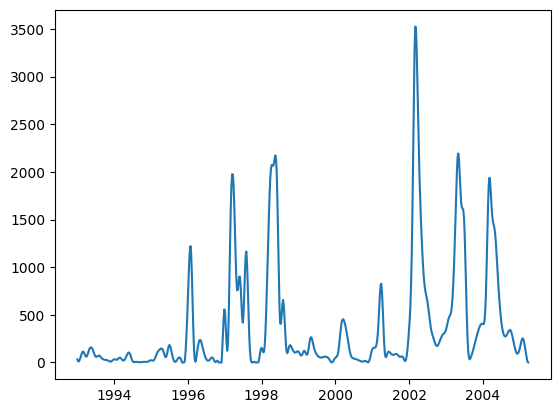

In [8]:
import pandas as pd
import numpy as np
from scipy.interpolate import UnivariateSpline

# Assume your pivot_df index is datetime (monthly data), sorted
pivot_df.index = pd.to_datetime(pivot_df.index)
pivot_df = pivot_df.sort_index()

# Extract ALAGOAS series
series = pivot_df['ALAGOAS']

# Convert datetime index to ordinal (numeric) for spline fitting
x_monthly = series.index.map(pd.Timestamp.toordinal).values
y_monthly = series.values

# Fit a univariate spline
spline = UnivariateSpline(x_monthly, y_monthly, s=0)  # s=0 means interpolation (passes exactly through the points)

# Now create weekly date range
weekly_index = pd.date_range(start=series.index.min(), end=series.index.max(), freq='W')

# Convert weekly dates to ordinal
x_weekly = weekly_index.map(pd.Timestamp.toordinal).values

# Evaluate the spline at weekly points
y_weekly = spline(x_weekly)

y_weekly = np.clip(y_weekly, 0, None)

# Create weekly pandas Series
weekly_series = pd.Series(y_weekly, index=weekly_index)

# Optional: round since you're dealing with counts
weekly_series = weekly_series.round().astype(int)



plt.plot(weekly_series)

In [11]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad
from tqdm import tqdm  # for progress bar

# ============================================
# Load Weekly Series
# ============================================

data = weekly_series.values.astype(np.float32)
data_max = np.max(data)
data_norm = data / data_max

data_tensor = torch.tensor(data_norm, dtype=torch.float32)  # (weeks,)
num_weeks = data_tensor.shape[0]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ============================================
# SEIR Model Dynamics (for cases)
# ============================================

def seir_derivatives(s, omega):
    S, E, I, R = s
    beta, alpha, gamma = omega
    N = S + E + I + R
    dSdt = -beta * S * I / N
    dEdt = beta * S * I / N - alpha * E
    dIdt = alpha * E - gamma * I
    dRdt = gamma * I
    return torch.stack([dSdt, dEdt, dIdt, dRdt], dim=0)

# ============================================
# PINN: Time Module
# ============================================

class TimeModule(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 4)
        )
        self.omega = nn.Parameter(torch.tensor([0.3, 0.2, 0.1]))  # beta, alpha, gamma

    def forward(self, t):
        return self.net(t)

# ============================================
# Feature Module (RNN)
# ============================================

class FeatureModule(nn.Module):
    def __init__(self, input_len=8):
        super().__init__()
        self.rnn = nn.GRU(1, 32, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 4)
        )
        self.input_len = input_len

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out

# ============================================
# Full training + forecasting function
# ============================================

def train_and_forecast(train_start_week, train_end_week, forecast_horizon=8):
    train_series = data_tensor[train_start_week:train_end_week].unsqueeze(1).to(device)
    test_series = data_tensor[train_end_week:train_end_week+forecast_horizon].to(device)
    train_weeks = train_end_week - train_start_week
    weeks_train = torch.arange(train_weeks, dtype=torch.float32, requires_grad=True).unsqueeze(1).to(device)

    time_module = TimeModule().to(device)
    feature_module = FeatureModule().to(device)
    optimizer_time = optim.Adam(time_module.parameters(), lr=1e-3)
    optimizer_feat = optim.Adam(feature_module.parameters(), lr=1e-3)

    # Train Time Module (PINN)
    for epoch in range(1000):
        optimizer_time.zero_grad()
        s_pred = time_module(weeks_train)
        grads = []
        for i in range(4):
            grad_i = grad(outputs=s_pred[:, i], inputs=weeks_train,
                          grad_outputs=torch.ones_like(s_pred[:, i]), create_graph=True)[0]
            grads.append(grad_i)
        dsdt_pred = torch.stack(grads, dim=1)

        ode_losses = []
        for t in range(train_weeks):
            s_t = s_pred[t]
            dsdt_t = dsdt_pred[t]
            omega = time_module.omega
            f_t = seir_derivatives(s_t, omega)
            ode_losses.append(torch.mean((dsdt_t - f_t) ** 2))
        loss_ode = torch.mean(torch.stack(ode_losses))

        observed_cases = s_pred[:, 2]  # use I as proxy for cases
        loss_data = nn.MSELoss()(observed_cases, train_series.squeeze())

        total_loss = loss_data + loss_ode
        total_loss.backward()
        optimizer_time.step()

    # Train Feature Module
    input_len = feature_module.input_len
    X_feat, Y_feat = [], []
    for t in range(input_len, train_weeks):
        window = train_series[t-input_len:t]
        X_feat.append(window)
        Y_feat.append(s_pred[t].detach())
    if len(X_feat) == 0:
        return None
    X_feat = torch.stack(X_feat).to(device)
    Y_feat = torch.stack(Y_feat).to(device)

    for epoch in range(500):
        optimizer_feat.zero_grad()
        outputs = feature_module(X_feat)
        loss_feat = nn.MSELoss()(outputs, Y_feat)
        loss_feat.backward()
        optimizer_feat.step()

    # Forecast autoregressively
    forecast = []
    input_window = train_series[-input_len:].unsqueeze(0).to(device)
    for _ in range(forecast_horizon):
        with torch.no_grad():
            pred_states = feature_module(input_window)
            pred_case = pred_states[:, 2].view(1, 1, 1)
            forecast.append(pred_case.cpu().numpy().flatten())
            next_input = torch.cat([input_window[:, 1:, :], pred_case], dim=1)
            input_window = next_input

    forecast = np.concatenate(forecast, axis=0)
    forecast_rescaled = forecast * data_max
    true_rescaled = test_series.cpu().numpy() * data_max
    return forecast_rescaled, true_rescaled

# ============================================
# Full rolling-origin evaluation with capped window
# ============================================

initial_train_weeks = 12
forecast_horizon = 8
stride = 2
max_train_weeks = 104

all_forecasts = []
all_truths = []

for start in tqdm(range(0, num_weeks - initial_train_weeks - forecast_horizon + 1, stride)):
    train_end = initial_train_weeks + start
    train_start = max(0, train_end - max_train_weeks)
    result = train_and_forecast(train_start, train_end, forecast_horizon)
    if result is not None:
        fcast, truth = result
        all_forecasts.append(fcast)
        all_truths.append(truth)

all_forecasts = np.concatenate(all_forecasts, axis=0)
all_truths = np.concatenate(all_truths, axis=0)
overall_mae = np.mean(np.abs(all_forecasts - all_truths))
print(f"\nOverall MAE: {overall_mae:.4f}")

100%|███████████████████████████████████████| 310/310 [1:00:34<00:00, 11.72s/it]


Overall MAE: 471.5036
